In [1]:
import datetime as dt
import sys
sys.path.insert(0,'../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from rivapy.tools.datetime_grid import DateTimeGrid
from rivapy.models.ornstein_uhlenbeck import OrnsteinUhlenbeck
from rivapy.models import WindPowerForecastModel, MultiRegionWindForecastModel, ResidualDemandForwardModel
from rivapy.pricing.green_ppa_pricing import price, price_new
from rivapy.instruments.ppa_specification import GreenPPASpecification
from rivapy.models.residual_demand_model import SmoothstepSupplyCurve
import numpy as np
from scipy.special import comb

%load_ext autoreload
%autoreload 2
%matplotlib inline

../../rivapy/__init__.py:11: UserWarning: The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.
  warnings.warn('The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.')
../../rivapy/pricing/green_ppa_pricing.py:7: UserWarning: Tensorflow is not installed. You cannot use the PPA pricer!
  warnings.warn('Tensorflow is not installed. You cannot use the PPA pricer!')


# Models

In [2]:
def smoothstep(x, x_min=0, x_max=1, N=1):
    x = np.clip((x - x_min) / (x_max - x_min), 0, 1)
    result = 0
    for n in range(0, N + 1):
         result += comb(N + n, n) * comb(2 * N + 1, N - n) * (-x) ** n
    result *= x ** (N + 1)
    return result

def _logit(x):
    return np.log(x/(1-x))

def _inv_logit(x):
    return 1.0/(1+np.exp(-x))


class SmoothstepSupplyCurve: 
    def __init__(self, s,N):
        self.s = s
        self.N = N
        
    def compute(self, residual, highest_price):
        #wind_production = wind_production#np.maximum(np.minimum(wind_production, 0.99), 0.01)
        #residual = (1.0-wind_production)
        residual = np.power(residual, self.s)
        return smoothstep(residual, N=self.N)*highest_price


- $p(t,T)$: Forward-Price zum Zeitpunkt $t$ mit Expiry $T$
- $f_i(t,T)$: Forecast der i-ten Technology für $T$ zum Zeitpunkt $t$
    - Annahme: Forecast stueckweise Konstant in der Zeit (Sprung an Forecast Terminen)


Wuenschenswert:
- $f_i(t,T)=E\left[f_i(T,T)\mid f_i(t,T)\right]$
- $p(t,T)=E\left[p(T,T)\mid p(t,T)\right]$

Einfache Moeglichkeit (ohne die wuenschenswerten Punkte einzuhalten): 
- $c(t,T)$: Hoechster Preis, der aufgrund der Angebotskurve zustande kommen kann
- $r(x)$: Residual demand curve mit Werten zwischen 0 und 1
$$
p(t,T) = c(t,T)\cdot r(1.0 - \sum_i f_i(t,T))
$$
Unabghängigkeit von $c$ und $f_i$:
$$
E\left[p(T,T)\right] = E\left[c(T,T)\right]E\left[r(1.0 - \sum_i f_i(T,T))\right]
$$
und wenn 
$$E\left[c(T,T))\right]=c(t,T)$$ 
und 
$$E\left[r(1.0 - \sum_i f_i(T,T)\right]=r(1.0 - \sum_i f_i(t,T))$$
haben wir $p(t,T)=E\left[p(T,T)\mid p(t,T)\right]$. Wenn $r$ linear, d.h. $r(x)=x$ dann einfach!


$$
dF = \lambda(F-a-r(f))dt + \sigma dW
$$

In [3]:
days = 2
timegrid = np.linspace(0.0, days*1.0/365.0, days*24)
forecast_points = [i for i in range(len(timegrid)) if i%8==0]
forward_expiries = [timegrid[-1] + 10*24*i/(365*24.0) for i in range(4)]
#forward_expiries = [timegrid[-1] + i for i in range(4)]
n_sims = 10_000
wind_forecast_model = WindPowerForecastModel(speed_of_mean_reversion=1.0, volatility=0.30, 
                             expiries=forward_expiries,
                            forecasts = [0.8, 0.8,0.8,0.8],#*len(forward_expiries)
                            )

rnd = np.random.normal(size=wind_forecast_model.rnd_shape(n_sims, timegrid.shape[0]))
wind = wind_forecast_model.simulate(timegrid, rnd)

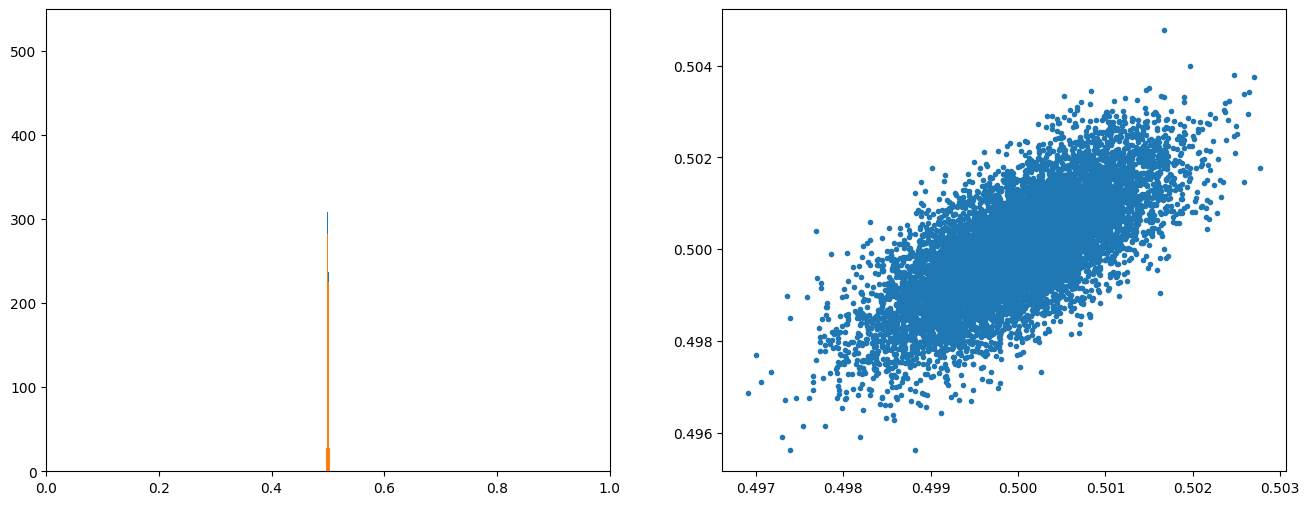

In [4]:
expiry1 = 1
expiry2 = 2#5*24
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.hist(_inv_logit(wind._paths[expiry1,:]), density=True, bins=100)
plt.hist(_inv_logit(wind._paths[expiry2,:]), density=True, bins=100)
plt.xlim(0.0,1.0)
plt.subplot(1,2,2)
plt.plot(_inv_logit(wind._paths[expiry1,:]), _inv_logit(wind._paths[expiry2,:]), '.');

In [5]:
wind_forecast_model_2 = WindPowerForecastModel(speed_of_mean_reversion=2.0, volatility=0.6, 
                             expiries=forward_expiries,
                            forecasts = [0.8, 0.8,0.8,0.8],#*len(forward_expiries)
                            )
region_wind_model = MultiRegionWindForecastModel([(0.5, wind_forecast_model, [0.6, 0.4]),
                              (0.5, wind_forecast_model_2, [0.4, 0.6])])

In [6]:
results = region_wind_model.simulate(timegrid, rnd)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
expiry = -1
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(_inv_logit(results[0]._paths[expiry,:]), _inv_logit(results[1]._paths[expiry,:]), '.');

plt.subplot(1,2,2)
plt.hist(_inv_logit(results[0]._paths[expiry,:]), density=True, label='region 0', bins=100)
plt.hist(_inv_logit(results[1]._paths[expiry,:]),  density=True, label='region 1', bins=100, alpha=0.8);


In [ ]:
for fwd in [0,-1]:#range(wind.n_forwards()):
    fwd_values = wind.get_fwd(0, fwd)
    plt.hist(fwd_values, bins=100, label='expiry ' + str(wind.expiry(fwd))[:6], alpha=0.3, density=True)
plt.legend();

In [ ]:
timestep = 20
fwd1 = 0
fwd2 = 1
fwd_values1 = wind.get_fwd(timestep, fwd1)
fwd_values2 = wind.get_fwd(timestep, fwd2)
plt.plot(fwd_values1, fwd_values2, '.', alpha=0.1)
plt.legend();

In [ ]:
highest_price = OrnsteinUhlenbeck(1.0, 1.0, mean_reversion_level=1.0)
supply_curve = SmoothstepSupplyCurve(1.0, 0)
rdm = ResidualDemandForwardModel(wind_forecast_model, highest_price, supply_curve)

In [ ]:
n_sims = 1000
rnd = np.random.normal(size=(2,timegrid.shape[0], n_sims))
fwd_prices, fwd_residuals = rdm.simulate(timegrid, rnd, forecast_points, highest_price=1000)

In [ ]:
plt.figure(figsize = (16,4))
plt.subplot(1,3,1)
for T in [-2,0]:
    label = 'T='+str(forward_expiries[T])[:6]
    color = None
    for i in range(100):
        lines = plt.plot(timegrid, fwd_prices[:,i,T], '-', alpha=0.1, label=label, color = color)
        color = lines[0].get_color()
        label=None
plt.xlabel('t')
plt.ylabel('$p(t,T)$')
plt.legend()
    #plt.plot(timegrid, result[:,i,2], '-r', alpha=0.1)
plt.subplot(1,3,2)
x = np.linspace(0.0,1.0,50)
plt.plot(x,rdm.supply_curve.compute(x, 1000))
plt.xlabel('residual demand')
plt.ylabel('price')
plt.subplot(1,3,3)
for T in [-2,0]:
    label = 'T='+str(forward_expiries[T])
    color = None
    for i in range(100):
        plt.plot(timegrid, 1.0-fwd_residuals[:,i,T], '-', color = color, alpha=0.1)
        color = lines[0].get_color()
        label=None
plt.xlabel('t')
plt.ylabel('$f_i(t,T)$')
plt.legend();

In [ ]:
plt.figure(figsize = (16,4))

for T in [0,1,2]:
    plt.subplot(1,3,T+1)
    label = 'T='+str(forward_expiries[T])[:6]
    plt.plot( 1.0-fwd_residuals[-1,:,T], fwd_prices[-1,:,T], '.', alpha=0.1, label=label)
    label=None
plt.ylabel('$p(T,T)$')
plt.xlabel('$f_i(T,T)$')
plt.legend();

In [ ]:
fwd_prices[-1,:,T].shape

In [ ]:
for i in range(100):
    plt.plot(timegrid, result[:,i,-2], '-b', alpha=0.1)
    #plt.plot(timegrid, result[:,i,2], '-r', alpha=0.1)

In [ ]:
wind = WindPowerForecastModel(speed_of_mean_reversion=0.20, volatility=0.4, 
                             expiries=[1.0+i/(365.0*24.0) for i in range(24)],
                            forecasts = [0.8-i*0.4/23.0 for i in range(24)])

timegrid = np.linspace(0.0, 1.0, 100)
rnd = np.random.normal(size=(timegrid.shape[0], 100_000))
paths = wind.simulate(timegrid, rnd)

expiry = 0
timepoint = 99
t = timegrid[timepoint]
fwd = wind.get_forward(paths[timepoint], t, expiry)
print(np.mean(fwd))
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.hist(fwd, bins = 100);
plt.subplot(1,2,2)
plt.plot(paths[timepoint], fwd,'.');

In [ ]:

timepoint = -1
forecast = 0.001
ou = OrnsteinUhlenbeck(speed_of_mean_reversion=0.20, volatility=0.4, mean_reversion_level=0.0)
timegrid = np.linspace(0.0, 1.0, 100)
#scaling = 
correction = _logit(forecast)-ou.compute_expected_value(0.0, timegrid[timepoint])

print(_inv_logit(ou.compute_expected_value(0.0, timegrid[timepoint])+correction))
rnd = np.random.normal(size=(timegrid.shape[0], 100_000))
paths = ou.simulate(timegrid, 0.0, rnd) + correction
paths_inv_logit = _inv_logit(paths)

#plt.hist(paths[-1,:], bins=100)
plt.hist(paths_inv_logit[timepoint,:], bins=100);
print('mean ou path ', np.mean(paths[timepoint,:]), 'inverse_logit of mean ',_inv_logit(np.mean(paths[timepoint,:])), 
      ' mean of inverse logit',np.mean(paths_inv_logit[timepoint,:]))

_logit(forecast)

## MultiRegionWindForecastModel

In [15]:
from rivapy.models.residual_demand_model import MultiRegionWindForecastModel
forward_expiries = [24.0*2/365.0]
regions = [ MultiRegionWindForecastModel.Region( 
                                    WindPowerForecastModel(speed_of_mean_reversion=0.5, 
                                                           volatility=1.80, 
                                                            expiries=forward_expiries,
                                                            forecasts = [0.8, 0.8,0.8,0.8],#*len(forward_expiries)
                                                            region = 'Onshore'
                                                            ),
                                    capacity=1000.0,
                                    rnd_weights=[0.7,0.3]
                                ),
           MultiRegionWindForecastModel.Region( 
                                    WindPowerForecastModel(speed_of_mean_reversion=0.5, 
                                                           volatility=1.80, 
                                                            expiries=forward_expiries,
                                                            forecasts = [0.8, 0.8,0.8,0.8],#*len(forward_expiries)
                                                            region = 'Offshore'
                                                            ),
                                    capacity=500.0,
                                    rnd_weights=[0.3,0.7]
                                )
           
          ]
days = 2 
timegrid = np.linspace(0.0, days*1.0/365.0, days*24)
multi_region_model = MultiRegionWindForecastModel(regions)
rnd = np.random.normal(size=multi_region_model.rnd_shape(1000, timegrid.shape[0]))
results = multi_region_model.simulate(timegrid, rnd)

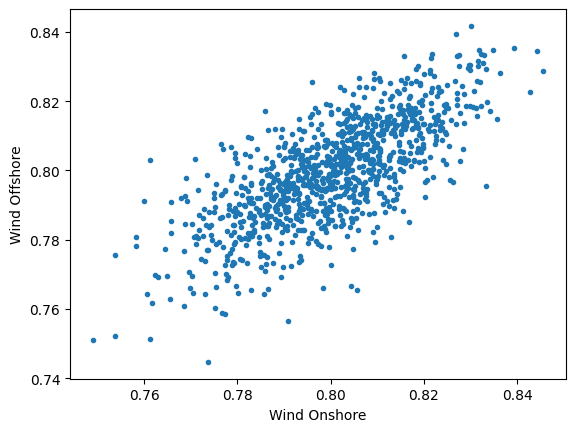

In [36]:
paths_1 = results['Onshore'].get_fwd(-1,-1)
paths_2 = results['Offshore'].get_fwd(-1,-1)
plt.plot(paths_1,paths_2,'.')
plt.xlabel('Wind Onshore')
plt.ylabel('Wind Offshore');

In [53]:
rdm = ResidualDemandForwardModel(multi_region_model, 
                                 highest_price,
                                SmoothstepSupplyCurve(1.0, 0),
                                 max_price = 1.0,
                                 #forecast_hours=[#6, 
                                 #                10, 14, 18], 
                                )
timegrid = np.linspace(0.0, days*1.0/365.0, days*24)
forecast_points = [i for i in range(len(timegrid)) if i%8==0]
forward_expiries = [timegrid[-1]]
n_sims = 1_000
rnd = np.random.normal(size=rdm.rnd_shape(n_sims, timegrid.shape[0]))
power_fwd, efficiencies = rdm.simulate(timegrid, rnd, forecast_points)

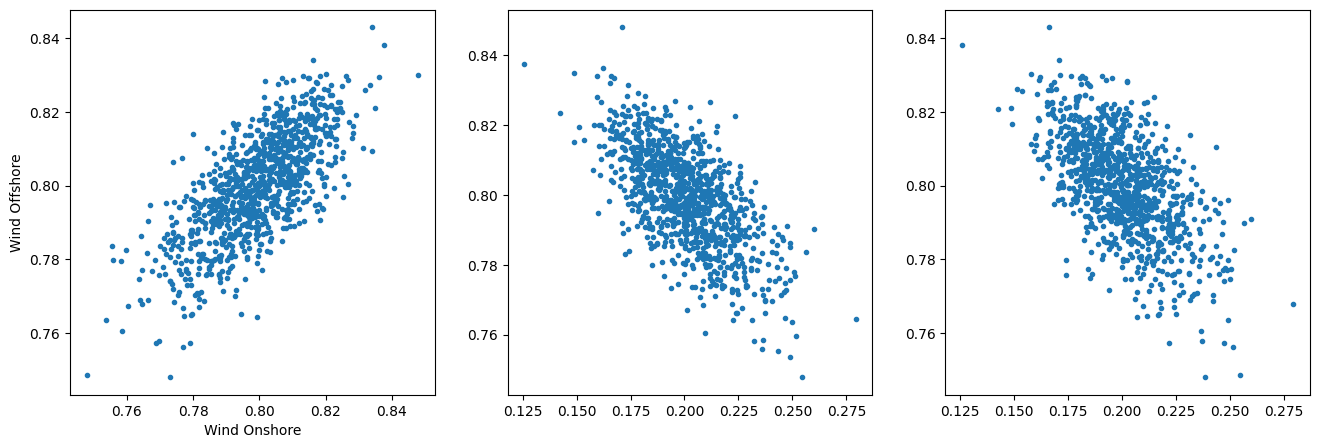

In [54]:
plt.figure(figsize=(16,5))
paths_1 = efficiencies['Onshore'][-1,:,-1]
paths_2 = efficiencies['Offshore'][-1,:,-1]
plt.subplot(1,3,1)
plt.plot(paths_1,paths_2,'.')
plt.xlabel('Wind Onshore')
plt.ylabel('Wind Offshore');
plt.subplot(1,3,2)
plt.plot(power_fwd[-1,:,-1],paths_1,'.')
plt.subplot(1,3,3)
plt.plot(power_fwd[-1,:,-1],paths_2,'.');

# Hedging

In [78]:
val_date = dt.datetime(2023,1,1)
days = 2
timegrid = np.linspace(0.0, days*1.0/365.0, days*24)
#forecast_points = [i for i in range(len(timegrid)) if i%8==0]
forward_expiries = [timegrid[-1]]
n_sims = 10_000

regions = [ MultiRegionWindForecastModel.Region( 
                                    WindPowerForecastModel(speed_of_mean_reversion=0.5, 
                                                           volatility=0.180, 
                                                            expiries=forward_expiries,
                                                            forecasts = [0.8, 0.8,0.8,0.8],#*len(forward_expiries)
                                                            region = 'Onshore'
                                                            ),
                                    capacity=1000.0,
                                    rnd_weights=[0.8,0.2]
                                ),
           MultiRegionWindForecastModel.Region( 
                                    WindPowerForecastModel(speed_of_mean_reversion=0.5, 
                                                           volatility=1.80, 
                                                            expiries=forward_expiries,
                                                            forecasts = [0.6, 0.6,0.6,0.6],#*len(forward_expiries)
                                                            region = 'Offshore'
                                                            ),
                                    capacity=100.0,
                                    rnd_weights=[0.2,0.8]
                                )
           
          ]
multi_region_wind_foecast_model = MultiRegionWindForecastModel(regions)
wind_forecast_model = multi_region_wind_foecast_model._region_forecast_models[0]

highest_price = OrnsteinUhlenbeck(1.0, 1.0, mean_reversion_level=1.0)
supply_curve = SmoothstepSupplyCurve(1.0, 0)
rdm = ResidualDemandForwardModel(
                                #wind_forecast_model, 
                                 multi_region_wind_foecast_model,
                                 highest_price,
                                 supply_curve,
                                 max_price = 1.0,
                                 forecast_hours=[6, 
                                                 10, 14, 18], 
                                #region_to_capacity=None
                                )

In [124]:
strike = 0.4#fwd_prices[:,-1].mean()
spec = GreenPPASpecification(technology = 'Wind',
                             location = 'Onshore',
                             schedule = [val_date + dt.timedelta(days=2)], 
                             fixed_price=strike,
                             max_capacity = 1.0)

In [125]:
tensorboard_logdir = os.path.join("logs", dt.datetime.now().strftime("%Y%m%d-%H%M%S"))
result = price(val_date, spec, rdm , 
               depth=3, nb_neurons=64, 
               n_sims = n_sims, regularization= 10.0, 
              epochs = 100, 
              verbose=1, 
              initial_lr = 1e-2,
              batch_size=400,
              decay_rate=0.6,
              tensorboard_logdir=tensorboard_logdir
            )

Epoch 1/100
25/25 [==============================] - 2s 62ms/step - loss: 0.0101
Epoch 2/100
25/25 [==============================] - 1s 44ms/step - loss: 2.0692e-04
Epoch 3/100
25/25 [==============================] - 1s 60ms/step - loss: 5.4716e-05
Epoch 4/100
25/25 [==============================] - 1s 39ms/step - loss: 4.3744e-05
Epoch 5/100
25/25 [==============================] - 1s 53ms/step - loss: 4.2428e-05
Epoch 6/100
25/25 [==============================] - 1s 49ms/step - loss: 4.1934e-05
Epoch 7/100
25/25 [==============================] - 1s 47ms/step - loss: 4.1633e-05
Epoch 8/100
25/25 [==============================] - 1s 45ms/step - loss: 4.1683e-05
Epoch 9/100
25/25 [==============================] - 1s 50ms/step - loss: 4.1390e-05
Epoch 10/100
25/25 [==============================] - 1s 47ms/step - loss: 4.1106e-05
Epoch 11/100
25/25 [==============================] - 1s 43ms/step - loss: 4.0572e-05
Epoch 12/100
25/25 [==============================] - 1s 43ms/step 

25/25 [==============================] - 1s 59ms/step - loss: 3.8727e-05
Epoch 95/100
25/25 [==============================] - 2s 63ms/step - loss: 3.6374e-05
Epoch 96/100
25/25 [==============================] - 1s 55ms/step - loss: 3.5683e-05
Epoch 97/100
25/25 [==============================] - 1s 49ms/step - loss: 3.6828e-05
Epoch 98/100
25/25 [==============================] - 1s 49ms/step - loss: 3.6669e-05
Epoch 99/100
25/25 [==============================] - 1s 50ms/step - loss: 4.0610e-05
Epoch 100/100
25/25 [==============================] - 1s 50ms/step - loss: 3.6922e-05


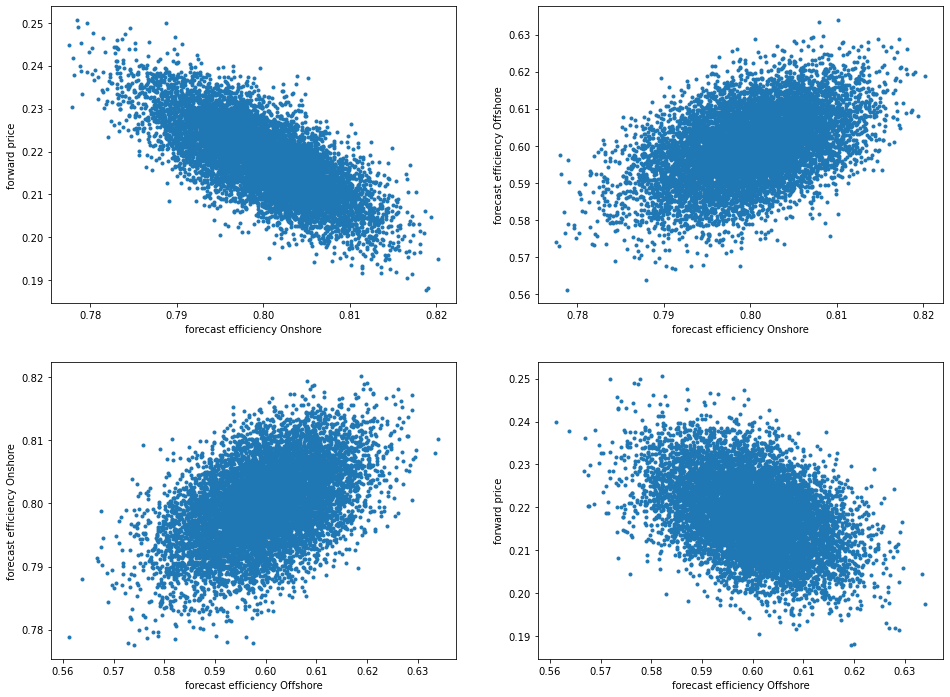

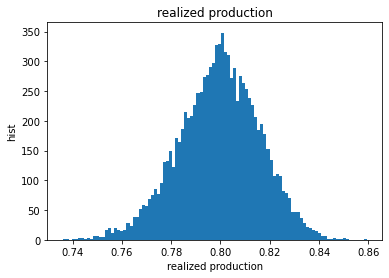

In [126]:
t=6
plt.figure(figsize=(16,12))
i=1
plt.title(str(result.timegrid.dates[t]))
for k,v in result.forecasts.items():
    for l,w in result.forecasts.items():
        plt.subplot(2,2,i) 
        if k==l:
            plt.plot(w[:,t], result.fwd_prices[:,t], '.')
            plt.xlabel('forecast efficiency ' + k)
            plt.ylabel('forward price')
        else:
            plt.plot(v[:,t], w[:,t], '.')
            plt.xlabel('forecast efficiency ' + k)
            plt.ylabel('forecast efficiency ' + l)
        i += 1
plt.figure()
plt.hist(result.rlzd_qty.reshape((-1)), bins=100)
plt.title('realized production')
plt.xlabel('realized production')
plt.ylabel('hist')
t = -2

strike 0.4
-0.145614323947407


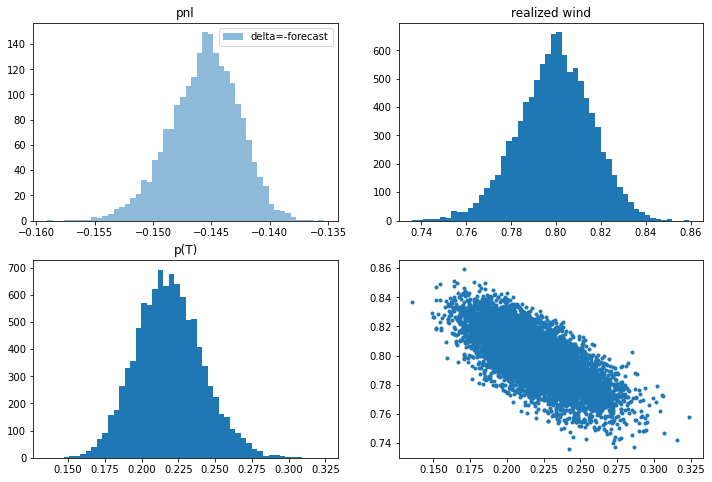

In [130]:
plt.figure(figsize=(12,8))
#forecast_points = [i for i in range(len(timegrid)) if i%8==0]
fwd_prices = result.fwd_prices
forecasts_ = result.forecasts[spec.location]
rlzd_qty = result.rlzd_qty


print('strike', strike)
plt.subplot(2,2,1)
#print('hedge_delta', (-fwd_residuals[-1]+1.0))
pnl_no_hedge = (fwd_prices[:,-1]-strike)*forecasts_[:,-1]
#bins = plt.hist(pnl_no_hedge, bins=50, label='no hedge', density=True)
delta = -1.0*forecasts_[:,0]
pnl_hedge = pnl_no_hedge + (fwd_prices[:,-1]-fwd_prices[:,0])*delta
plt.hist(pnl_hedge,  label='delta=-forecast', alpha=0.5, density=True, bins=50)
print(pnl_hedge.mean())
delta = -1.0*forecasts_[:,0]
#pnl_hedge = pnl_no_hedge + (fwd_prices[:,-1]-fwd_prices[:,0])*delta
#plt.hist(pnl_hedge,  label='delta=-forecast', alpha=0.5, density=True, bins=50)
#print(pnl_hedge.mean())

pnl_hedge_dynamic_volume = -fwd_prices[:,0]*forecasts_[:,0]
for i in range(1,fwd_prices.shape[1]):
    pnl_hedge_dynamic_volume += (forecasts_[:,i-1]-forecasts_[:,i])*fwd_prices[:,i]
pnl_hedge_dynamic_volume += forecasts_[:,-2]*fwd_prices[:,-1] + forecasts_[:,-1]*(fwd_prices[:,-1]-strike)
#plt.hist(pnl_hedge_dynamic_volume,  label='dynamic delta=-forecast', alpha=0.5, density=True, bins=50)

#delta = -0pnl_hedge_dynamic_volume8*(-fwd_residuals[0,:]+1.0)
#pnl_hedge = pnl_no_hedge + (fwd_prices[-1,:]-fwd_prices[0,:])*delta
#plt.hist(pnl_hedge,  label='delta=-0.8*forecast', alpha=0.5, density=True, bins=50)
plt.legend()
plt.title('pnl')
plt.subplot(2,2,2)
plt.hist(forecasts_[:,-1], bins=50);
plt.title('realized wind')
plt.subplot(2,2,3)
plt.hist(fwd_prices[:,-1], bins=50)
plt.title('p(T)')
plt.subplot(2,2,4)
plt.plot(fwd_prices[:,-1], forecasts_[:,-1],'.');

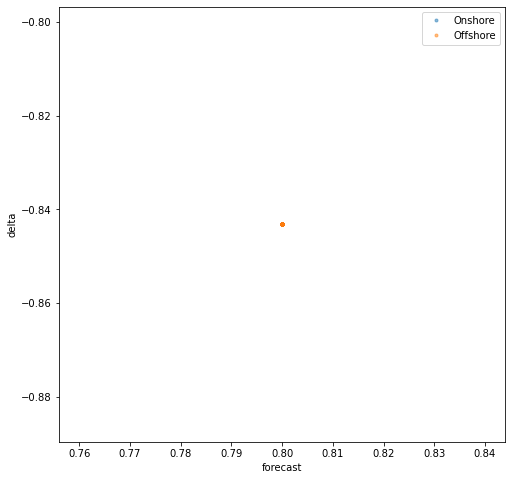

In [134]:
t = 0
plt.figure(figsize=(8,8))
#delta = result.hedge_model.model.predict([fwd_prices[:,t], forecasts[:,t], np.array([timegrid[t]]*forecasts.shape[0])]).reshape((-1))
delta = result.hedge_model.compute_delta(fwd_prices, forecasts, t)
for k,v in forecasts.items():
    plt.plot( v[:,t], delta,'.', label=k, alpha=0.5)
plt.ylabel('delta')
plt.xlabel('forecast')
plt.legend();

0.002940631176008395 0.0020406996
-0.145614323947407 -0.14567009


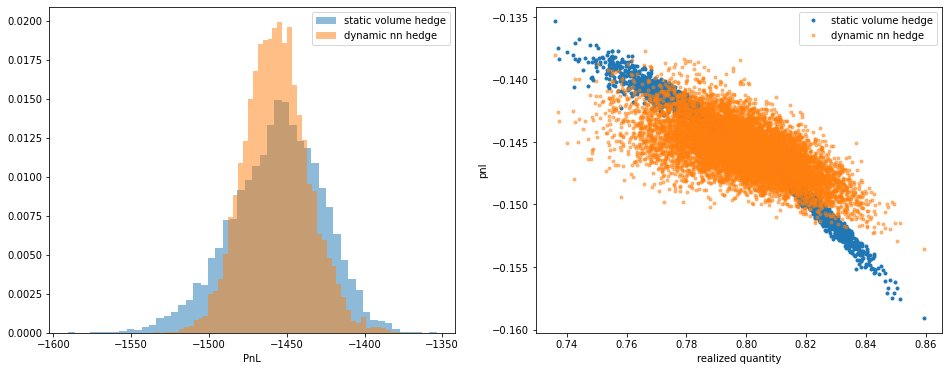

In [136]:
#plt.hist(pnl_no_hedge, bins=50, density=True, label='unhedged')
pnl = result.hedge_model.compute_pnl(fwd_prices, forecasts, result.rlzd_qty)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.hist(10000*pnl_hedge, bins=50, density=True, alpha=0.5, label='static volume hedge')
plt.hist(10000*pnl, bins=50, density=True, alpha=0.5, label='dynamic nn hedge')
plt.xlabel('PnL')
plt.legend();
print(np.sqrt(pnl_hedge.var()), np.sqrt(pnl.var()))
print(pnl_hedge.mean(), pnl.mean())
plt.subplot(1,2,2)
plt.plot(rlzd_qty, pnl_hedge, '.', label='static volume hedge')
plt.plot(rlzd_qty, pnl, '.', alpha=0.5, label='dynamic nn hedge')
plt.xlabel('realized quantity')
plt.ylabel('pnl')
plt.legend()
plt.savefig('deep_hedging.png', dpi=600)